## Mixture Kernel With non-stationary local weight

The Gaussian process in consideration is a mixture of independent processes. In specific, there is one global process $\mathcal{GP}_{g}$ and a collection of local processes $\{\mathcal{GP}_{l_i}\}$. A local non-stationary weight is added to each of the processes, to balance between exploring with global process and exploiting with local processes. The weight is modeled as Gaussian functions, to give the expression below:
\begin{gather*}
    f(\mathbf{x}) = e^{-\frac{\lVert \mathbf{x}-\pmb{\psi_g}\rVert_2^2}{2*\sigma_g^2}} f_{g}(\mathbf{x}) + \sum_i e^{-\frac{\lVert \mathbf{x}-\pmb{\psi_l}\rVert_2^2}{2*\sigma_{l_i}^2}} f_{l_i}(\mathbf{x}),\\
    f_{g} \sim \mathcal{GP}_{g},\quad f_{l_i} \sim \mathcal{GP}_{l_i},
\end{gather*}

$\pmb{\psi}$ denotes the position of the center of the influence region of a process.

Additivity of Gaussian processes results in the sum being Gaussian processes. If we further assume no correlation between the $\mathcal{GP}$ s, then we may describe $\mathcal{GP}_{tot}:\ f(\mathbf{x})\sim\mathcal{GP}_{tot}$ uniquely with mean function and covariance kernel as:

\begin{align*}
    k(\mathbf x_1, \mathbf x_2) = &\exp\left(\frac{\lVert \mathbf{x_1}-\pmb{\psi_g}\rVert_2^2 + \lVert \mathbf{x_2}-\pmb{\psi_g}\rVert_2^2}{2\sigma_g^2}\right)k_g(\mathbf x_1, \mathbf x_2)\\
    &+\sum_i \exp\left(\frac{\lVert \mathbf{x_1}-\pmb{\psi_g}\rVert_2^2 + \lVert \mathbf{x_2}-\pmb{\psi_g}\rVert_2^2}{2\sigma_{l_i}^2}\right)k_{l_i}(\mathbf x_1, \mathbf x_2),\\
        m(\mathbf x) = & m_g(\mathbf{x}) + \sum_i m_{l_i}(\mathbf{x}) 
\end{align*}


Our assumptions are: 1). Local Kernels are at a same place, and the areas of influence are isotropic. 2). input of $\mathbf x$ is vaguely standardized to $[-1,1]_d$, which can be used for setting the priors of sub-kernel hyperparameters and position/weights hyperparameters. 3). Global kernel has near uniform weight, which can be simulated by placing at $\pmb{\psi_g} = [0.5]_d$ and $\sigma_g$ being large, e.g. taken to be 10. 4). Global weight $\sigma_g$ isn't a hyperparameter, while local weights $\sigma_{l_i}$ s are hyperparameters. If necessary, we can use a unified $\sigma_{l}$. 5). To emphasize the local/global weights, $\sigma_l \ll \sigma_g$ might also be necessary. The practical hyperparameter might be $\sigma_l/\sigma_g$, constrained to $(0,1)$, or its logarithm constrained to $(-\infty,0)$, instead of $\sigma_l$.


In [1]:
# Imports

import torch, gpytorch
from GaussianWeightSpartan import Gaussian_Weight_Spartan_Kernel
from Spartan import SpartanKernel

/home/huaiyuli/.conda/envs/GPTorchdev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we show a rough example that the code works, before testing priors:

In [2]:
# Plotting function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def plot_gptorch(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval for models defined in GPyTorch """
    X_ = X.numpy()
    m_ = m.numpy()
    C_ = C.numpy()
    # Plot 95% confidence interval
    plt.fill_between(X_[:],
                     m_[:] - 1.96*np.sqrt(C_),
                     m_[:] + 1.96*np.sqrt(C_),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X_, m_, "-")
    plt.legend(labels=["GP fit"])

    plt.xlabel("x"), plt.ylabel("f")

    # Plot training points if included
    if training_points is not None:
        X__, Y__ = (training_points[0].numpy().reshape(-1),training_points[1].numpy().reshape(-1))
        plt.plot(X__, Y__, "kx", mew=2)
        plt.legend(labels=["GP fit", "GP center", "sample points"])


In [3]:
# model definition
from gpytorch.kernels import RBFKernel
from gpytorch.priors import LogNormalPrior, NormalPrior
class Loc_1D_RBF(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(Loc_1D_RBF, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(1), 
                                          [RBFKernel(1, lengthscale_prior=
                                          NormalPrior(0.1,0.05)) for i in range(2)],
                                          ard_num_dims=1,
                                          local_position_prior=NormalPrior(0.5,0.2),
                                          local_weight_var_prior=NormalPrior(0.1,0.05))
        covar_module.global_kernel.register_prior("lengthscale_prior", 
                                    LogNormalPrior(loc = torch.zeros(1), scale=1*torch.ones(1)),
                                    covar_module.global_kernel._lengthscale_param,
                                    covar_module.global_kernel._lengthscale_closure)
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)1
    

In [21]:
# Defining training data
from math import pi
steps = 20
Xt = torch.linspace(0,1,20, dtype=torch.float64)
yt_func = lambda x: torch.sin(torch.pow((x),4.)*4*pi)
Yt= yt_func(Xt) + torch.randn_like(Xt)*0.05




Iter 1 - Loss: 0.261 noise: 0.149 variance: 0.431 position: 0.656 locallengthscale: 0.109 globallengthscale: 0.674 localweightvar: 0.109
Iter 2 - Loss: 0.236 noise: 0.117 variance: 0.227 position: 0.682 locallengthscale: 0.087 globallengthscale: 0.374 localweightvar: 0.118
Iter 3 - Loss: 0.011 noise: 0.006 variance: 0.970 position: 0.893 locallengthscale: 0.017 globallengthscale: 0.145 localweightvar: 0.045
Iter 4 - Loss: -0.114 noise: 0.004 variance: 0.355 position: 0.876 locallengthscale: 0.032 globallengthscale: 0.141 localweightvar: 0.059
Iter 5 - Loss: -0.373 noise: 0.001 variance: 0.457 position: 0.877 locallengthscale: 0.045 globallengthscale: 0.160 localweightvar: 0.103
Iter 6 - Loss: -0.374 noise: 0.001 variance: 0.419 position: 0.872 locallengthscale: 0.044 globallengthscale: 0.157 localweightvar: 0.103
Iter 7 - Loss: -0.374 noise: 0.001 variance: 0.416 position: 0.872 locallengthscale: 0.044 globallengthscale: 0.157 localweightvar: 0.103
Iter 8 - Loss: -0.374 noise: 0.001 va

Text(0.5, 1.0, 'GPyTorch regression model fit with likelihood, Spartan RBF')

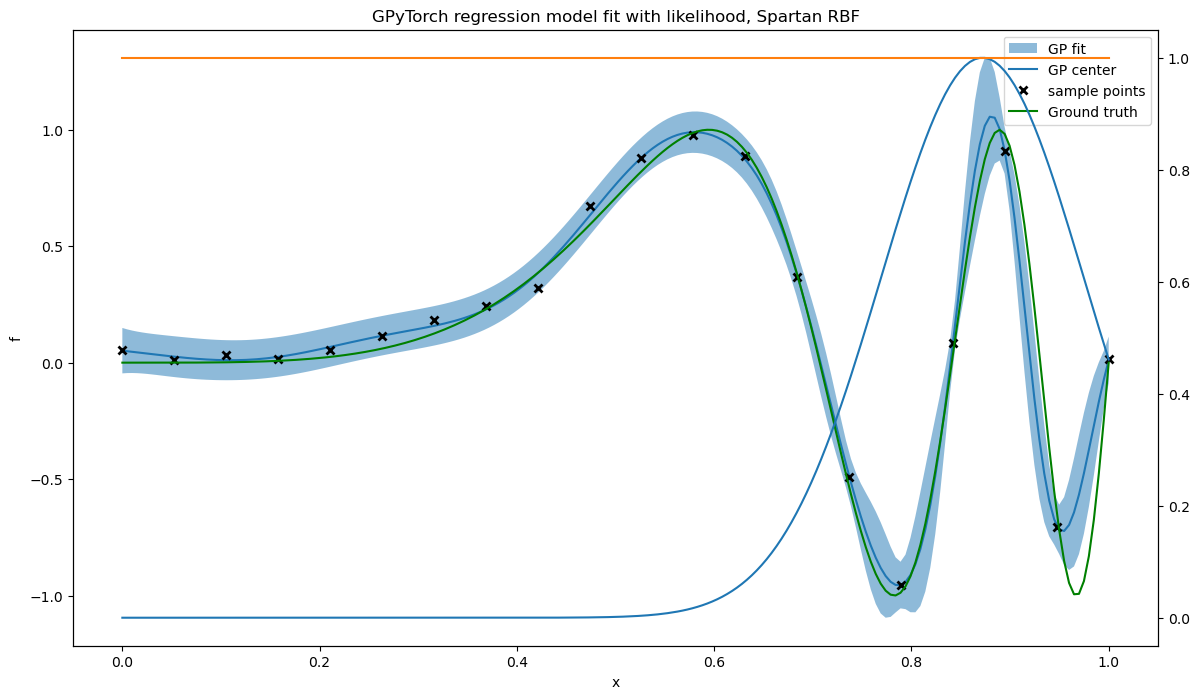

In [22]:
from gpytorch.constraints import Interval
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(lower_bound=1e-6, upper_bound = 1))
model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)

import timeit
Xt = Xt.cpu()
Yt = Yt.cpu()

start_time = timeit.default_timer()
# Spartan
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(lower_bound=1e-6, upper_bound = 1))
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
model0.covar_module.base_kernel._set_local_position(0.5)
#for lk in model0.covar_module.base_kernel.local_kernels:
#    lk.raw_lengthscale_constraint = Interval(lower_bound=0.05, 
#                                             upper_bound=0.2)
model0.train()
likelihood.train()
training_iter = 50
optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
# "Loss" for GPs - the marginal log likelihood
#model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

losstrack = 100
lossdif = 100
numcount = 0
steplength = torch.tensor([1])
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
        optimizer.zero_grad()
        # Output from model
        output = model0(Xt)
        # Calc loss and backprop gradients
        loss = -mll(output, Yt)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
            i + 1, loss.item(),
            #model.covar_module.base_kernel.lengthscale.item(),
            model0.likelihood.noise.item(),
            model0.covar_module.outputscale.item(),
            model0.covar_module.base_kernel.local_position.item(),
            model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
            model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
            model0.covar_module.base_kernel.local_weight_var[0].item()
        ))
model0.eval()
likelihood.eval()

end_time = timeit.default_timer()

elapsed_time = end_time - start_time
print(f'Time elapsed: {elapsed_time} seconds')

Xtnew = torch.linspace(0,1,200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
             training_points=(Xt, Yt))
plt.plot(Xtnew, yt_func(Xtnew), 'g')
plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
weights = plt.twinx()
#model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
firstkernel=True, log_prob = False).detach().numpy())
weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())
plt.title("GPyTorch regression model fit with likelihood, Spartan RBF")

In [23]:
with torch.no_grad():
    for name, param in model0.named_parameters():
        print(name, param)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-6.6389], requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0.2220, requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(-0.6630, requires_grad=True)
covar_module.base_kernel.local_position Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.base_kernel.raw_local_weight_var Parameter containing:
tensor([-2.1653, -2.1653], requires_grad=True)
covar_module.base_kernel._local_position Parameter containing:
tensor(0.8719, requires_grad=True)
covar_module.base_kernel.global_kernel.raw_lengthscale Parameter containing:
tensor([[-1.7718]], requires_grad=True)
covar_module.base_kernel.local_kernels.0.raw_lengthscale Parameter containing:
tensor([[-3.0981]], requires_grad=True)
covar_module.base_kernel.local_kernels.1.raw_lengthscale Parameter containing:
tensor([[-3.0981]], requires_grad=True)


We test the model without any priors or constraints, initiating at different locations, and observe the results:

In [7]:
from gpytorch.constraints import Positive

class Loc_1D_RBF_Free(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(Loc_1D_RBF_Free, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(1), 
                                          [RBFKernel(1) for i in range(1)],
                                          ard_num_dims=1,
                                          local_weight_var_constraint=Positive())
        #covar_module.global_kernel.register_prior("lengthscale_prior", 
        #                            LogNormalPrior(loc = torch.zeros(1), scale=1*torch.ones(1)),
        #                            covar_module.global_kernel._lengthscale_param,
        #                            covar_module.global_kernel._lengthscale_closure)
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Iter 1 - Loss: 0.322 noise: 0.180 variance: 0.758 position: 0.650 locallengthscale: 0.086 globallengthscale: 1.245 localweightvar: 0.101
Iter 2 - Loss: 0.245 noise: 0.114 variance: 0.308 position: 0.655 locallengthscale: 0.099 globallengthscale: 0.691 localweightvar: 0.118
Iter 3 - Loss: 0.231 noise: 0.105 variance: 0.205 position: 0.793 locallengthscale: 0.069 globallengthscale: 0.208 localweightvar: 0.109
Iter 4 - Loss: -0.238 noise: 0.002 variance: 0.779 position: 0.856 locallengthscale: 0.040 globallengthscale: 0.166 localweightvar: 0.073
Iter 5 - Loss: -0.356 noise: 0.001 variance: 0.433 position: 0.879 locallengthscale: 0.071 globallengthscale: 0.161 localweightvar: 0.127
Iter 6 - Loss: -0.377 noise: 0.001 variance: 0.437 position: 0.875 locallengthscale: 0.064 globallengthscale: 0.160 localweightvar: 0.114
Iter 7 - Loss: -0.378 noise: 0.001 variance: 0.485 position: 0.878 locallengthscale: 0.068 globallengthscale: 0.162 localweightvar: 0.115
Iter 8 - Loss: -0.378 noise: 0.001 va

Text(0.5, 1.0, 'GPyTorch regression model fit with likelihood, Spartan RBF')

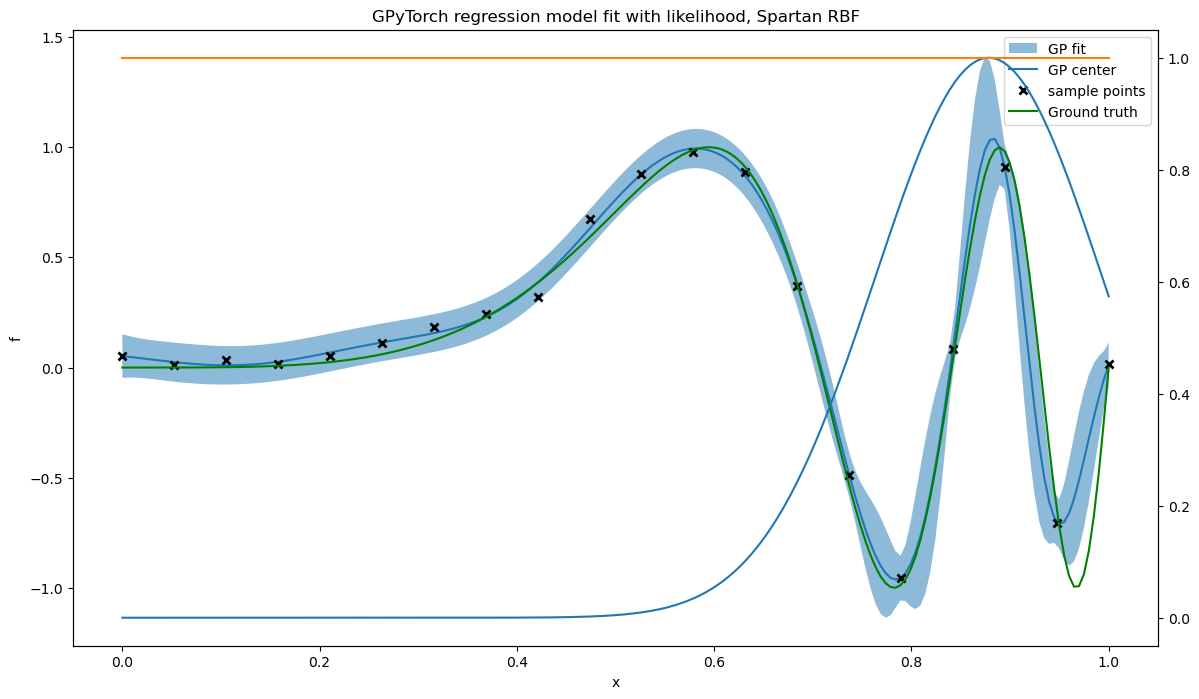

In [27]:
start_time = timeit.default_timer()
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=Interval(1e-8,1.))
model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)
model0.covar_module.base_kernel._set_local_position(0.5)
model0.train()
likelihood.train()
for name, params in model0.named_hyperparameters():
    params.data.copy_(torch.rand_like(params.data)*2)
training_iter = 20
optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
start_time = timeit.default_timer()
# "Loss" for GPs - the marginal log likelihood
#model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

losstrack = 100
lossdif = 100
numcount = 0
steplength = torch.tensor([1])
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
        optimizer.zero_grad()
        # Output from model
        output = model0(Xt)
        # Calc loss and backprop gradients
        loss = -mll(output, Yt)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
            i + 1, loss.item(),
            #model.covar_module.base_kernel.lengthscale.item(),
            model0.likelihood.noise.item(),
            model0.covar_module.outputscale.item(),
            model0.covar_module.base_kernel.local_position.item(),
            model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
            model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
            model0.covar_module.base_kernel.local_weight_var[0].item()
        ))
model0.eval()
likelihood.eval()

end_time = timeit.default_timer()

elapsed_time = end_time - start_time
print(f'Time elapsed: {elapsed_time} seconds')

Xtnew = torch.linspace(0,1,200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
             training_points=(Xt, Yt))
plt.plot(Xtnew, yt_func(Xtnew), 'g')
plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
weights = plt.twinx()
#model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
firstkernel=True, log_prob = False).detach().numpy())
weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())
plt.title("GPyTorch regression model fit with likelihood, Spartan RBF")
